<a href="https://colab.research.google.com/github/t07902301/Reddit-Topics/blob/main/Spark_in_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisites
Sign up to https://ngrok.com/ to be able to reach Spark UI

In [1]:
%%capture
!pip install pyspark
!pip install findspark
# !pip install pyngrok

In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder \
        .appName('testColab') \
        .getOrCreate()

In [37]:
# prompt: clean a string with spark by remove stopwords, punctuation, and perform tokenization

import findspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, lower, regexp_replace
from pyspark.ml.feature import StopWordsRemover, Tokenizer
import json
from pyspark.sql.types import ArrayType, StringType

findspark.init()
spark = SparkSession.builder \
        .appName('testColab') \
        .getOrCreate()

# Read Subreddit JSON (assuming it's in the correct location)
with open('/content/cscareerquestions.json', 'r') as file:
    data = json.load(file)

extracted_posts = [{'url': post['data']['url'], 'content': post['data']['title'] + ' ' + post['data']['selftext']} for post in data['data']['children']]

# Create a DataFrame
df = spark.createDataFrame(extracted_posts)

# 1. Convert to lowercase
df = df.withColumn("content", lower(col("content")))

# 2. Remove punctuation
df = df.withColumn("content", regexp_replace(col("content"), "[^a-zA-Z\\s]", ""))


# 3. Tokenize
tokenizer = Tokenizer(inputCol="content", outputCol="tokens")
df = tokenizer.transform(df)

# 4. Remove stop words
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
df = remover.transform(df)

# Custom UDF to filter words by length
def filter_short_words(words):
    return [word for word in words if len(word) > 3]  # Keep words longer than 2 characters

filter_udf = udf(filter_short_words, ArrayType(StringType()))
df = df.withColumn("meaningful_wtokens", filter_udf(col("filtered_tokens")))

# Show the DataFrame with the cleaned text
df.select("url", "meaningful_wtokens").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [40]:
# prompt: Count frequencies of filtered_tokens in a spark dataframe

from pyspark.sql.functions import explode, count

# Explode the filtered_tokens array into separate rows
exploded_df = df.select("url", explode("meaningful_wtokens").alias("token"))

# Group by token and count occurrences
token_counts = exploded_df.groupBy("token").agg(count("*").alias("frequency"))

# Show the token counts
token_counts.show()

+---------+---------+
|    token|frequency|
+---------+---------+
|   online|        4|
|    still|        7|
|   worked|        4|
|  prevent|        1|
|  traffic|        1|
|     grow|        1|
|   thread|        7|
|     used|        4|
| graduate|        1|
|basically|        3|
|    crazy|        1|
|     even|        9|
|   slower|        1|
|  earlier|        1|
| codebase|        1|
|   highly|        1|
|    froze|        2|
| frontend|        8|
| instance|        1|
|component|        2|
+---------+---------+
only showing top 20 rows



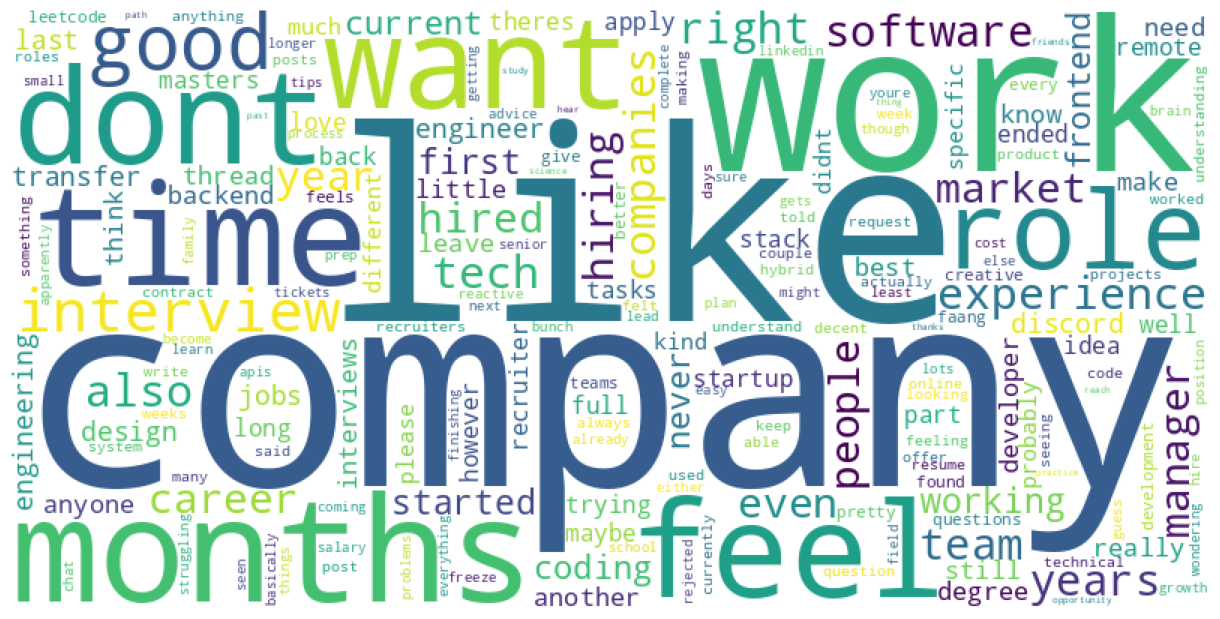

In [41]:
# prompt: create a word cloud based on counted word frequencies

import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Assuming 'word_counts' is your DataFrame with 'word' and 'count' columns as shown in the previous code snippet.
# If 'word_counts' is not available, execute the previous code before this cell.

# Convert the Spark DataFrame to a Pandas DataFrame
word_counts_pandas = token_counts.toPandas()

# Create a dictionary of word frequencies
word_freq = dict(zip(word_counts_pandas['token'], word_counts_pandas['frequency']))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Display the generated image:
plt.figure(figsize=(12, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()